In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196769
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=4)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=4,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/196769/fs/196688/fv/wine/version/4


In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.12s) 


KNeighborsClassifier(n_neighbors=2)

In [5]:
X_train

,volatile_acidity,chlorides,density,alcohol
0,0.400,0.071,0.99462,12.5
2,0.300,0.046,0.99775,9.5
4,0.450,0.080,0.99560,9.4
5,0.260,0.071,0.99860,9.3
6,0.180,0.051,0.99530,10.6
...,...,...,...,...
5273,0.305,0.059,0.99331,11.5
5275,0.900,0.079,0.99670,9.8
5277,0.460,0.077,0.99480,10.6
5280,0.670,0.290,0.99840,9.0


In [6]:
y_train

,quality
0,8
2,6
4,5
5,6
6,6
...,...
5273,6
5275,5
5277,6
5280,4


In [7]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [10]:
print(metrics)

{'3': {'precision': 0.125, 'recall': 0.14285714285714285, 'f1-score': 0.13333333333333333, 'support': 7}, '4': {'precision': 0.03529411764705882, 'recall': 0.0625, 'f1-score': 0.045112781954887216, 'support': 48}, '5': {'precision': 0.4685598377281947, 'recall': 0.648876404494382, 'f1-score': 0.5441696113074205, 'support': 356}, '6': {'precision': 0.5076530612244898, 'recall': 0.4461883408071749, 'f1-score': 0.47494033412887826, 'support': 446}, '7': {'precision': 0.4533333333333333, 'recall': 0.19540229885057472, 'f1-score': 0.27309236947791166, 'support': 174}, '8': {'precision': 0.75, 'recall': 0.12, 'f1-score': 0.20689655172413793, 'support': 25}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.445600756859035, 'macro avg': {'precision': 0.3342629071332967, 'recall': 0.23083202671561068, 'f1-score': 0.23964928313236697, 'support': 1057}, 'weighted avg': {'precision': 0.46681143347627113, 'recall': 0.445600756859035, 'f1-score': 0.436458849192383

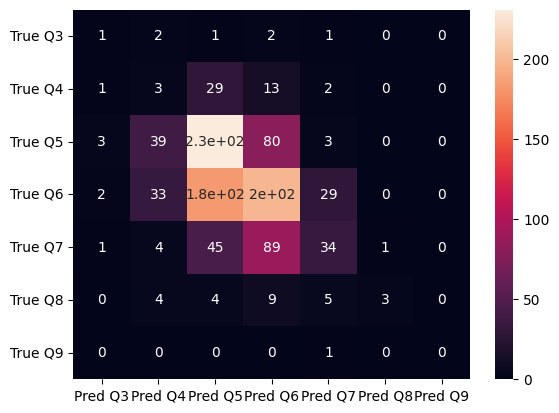

In [11]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Q3', 'True Q4', 'True Q5', 'True Q6', 'True Q7', 'True Q8', 'True Q9'],
                     ['Pred Q3', 'Pred Q4', 'Pred Q5', 'Pred Q6', 'Pred Q7', 'Pred Q8', 'Pred Q9'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [12]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/wine_confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/196769/models/wine_model/2


Model(name: 'wine_model', version: 2)